In [ ]:
%matplotlib inline
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import scipy as sp
import json

In [ ]:
def plot_imgs(img1, img2, img3, img4):
  fig, ax = plt.subplots(1, 4, figsize=(30, 20))
  for a in ax:
    a.set_axis_off()
  ax[0].imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
  ax[0].set_title("Original image")
  ax[1].imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))
  ax[1].set_title("Translation in image plane")
  ax[2].imshow(cv2.cvtColor(img3,cv2.COLOR_BGR2RGB))
  ax[2].set_title("Rotation about optical axis")
  ax[3].imshow(cv2.cvtColor(img4,cv2.COLOR_BGR2RGB))
  ax[3].set_title("Translation along optical axis")

In [ ]:
def plot_imgs2(img1, img2):
  fig, ax = plt.subplots(1, 2, figsize=(30, 20))
  for a in ax:
    a.set_axis_off()
  ax[0].imshow(cv2.cvtColor(img1,cv2.COLOR_BGR2RGB))
  ax[0].set_title("Original image")
  ax[1].imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB))
  ax[1].set_title("Transformed original image to imitate optical flow")

In [ ]:
im1 = cv2.imread("init_frame.png", cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread("trans_frame.png", cv2.IMREAD_GRAYSCALE)
im3 = cv2.imread("rot_frame.png", cv2.IMREAD_GRAYSCALE)
im4 = cv2.imread("depth_frame.png", cv2.IMREAD_GRAYSCALE)
imgs = [im2, im3, im4]

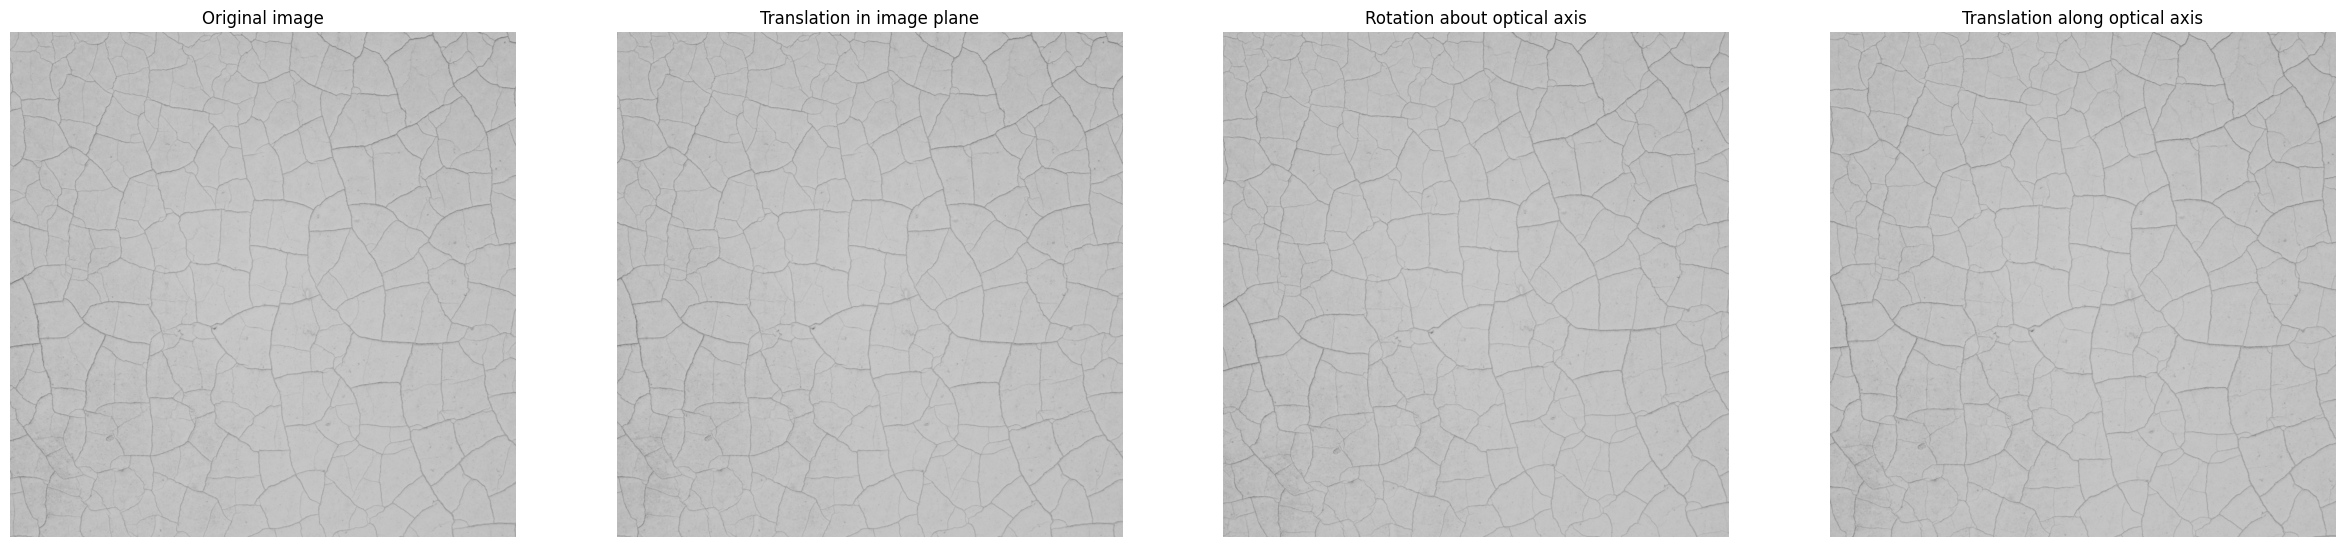

In [ ]:
plot_imgs(im1, im2, im3, im4)

## Lucas-Kanade (Sparse Optical Flow)

In [ ]:
def get_optical_flow(im1, im2):
  # find corners
  corners = cv2.goodFeaturesToTrack (im1,
    maxCorners=2000, qualityLevel=0.1,
    minDistance=10, blockSize=15)

  # calculate optical flow
  #squeeze().astype(np.float32)
  pts_left = corners
  pts_right = np.empty_like(pts_left)
  pts_right, status, err = cv2.calcOpticalFlowPyrLK(
    im1, im2, pts_left, pts_right, maxLevel=10)

  # Select good points
  if pts_right is not None:
      good_right = pts_right[status==1]
      good_left = pts_left[status==1]

  # Draw vector field
  im_with_flow = cv2.cvtColor(im1,cv2.COLOR_GRAY2RGB)
  #mask = np.zeros_like(im_with_flow) # we will draw on mask first before merging with the image
  for left, right in zip(good_left, good_right):
        a1, a2 = left.ravel()
        b1, b2 = right.ravel()
        im_with_flow = cv2.line(im_with_flow, (int(a1), int(a2)), (int(b1), int(b2)), (0, 0, 255), 2)
  return im_with_flow

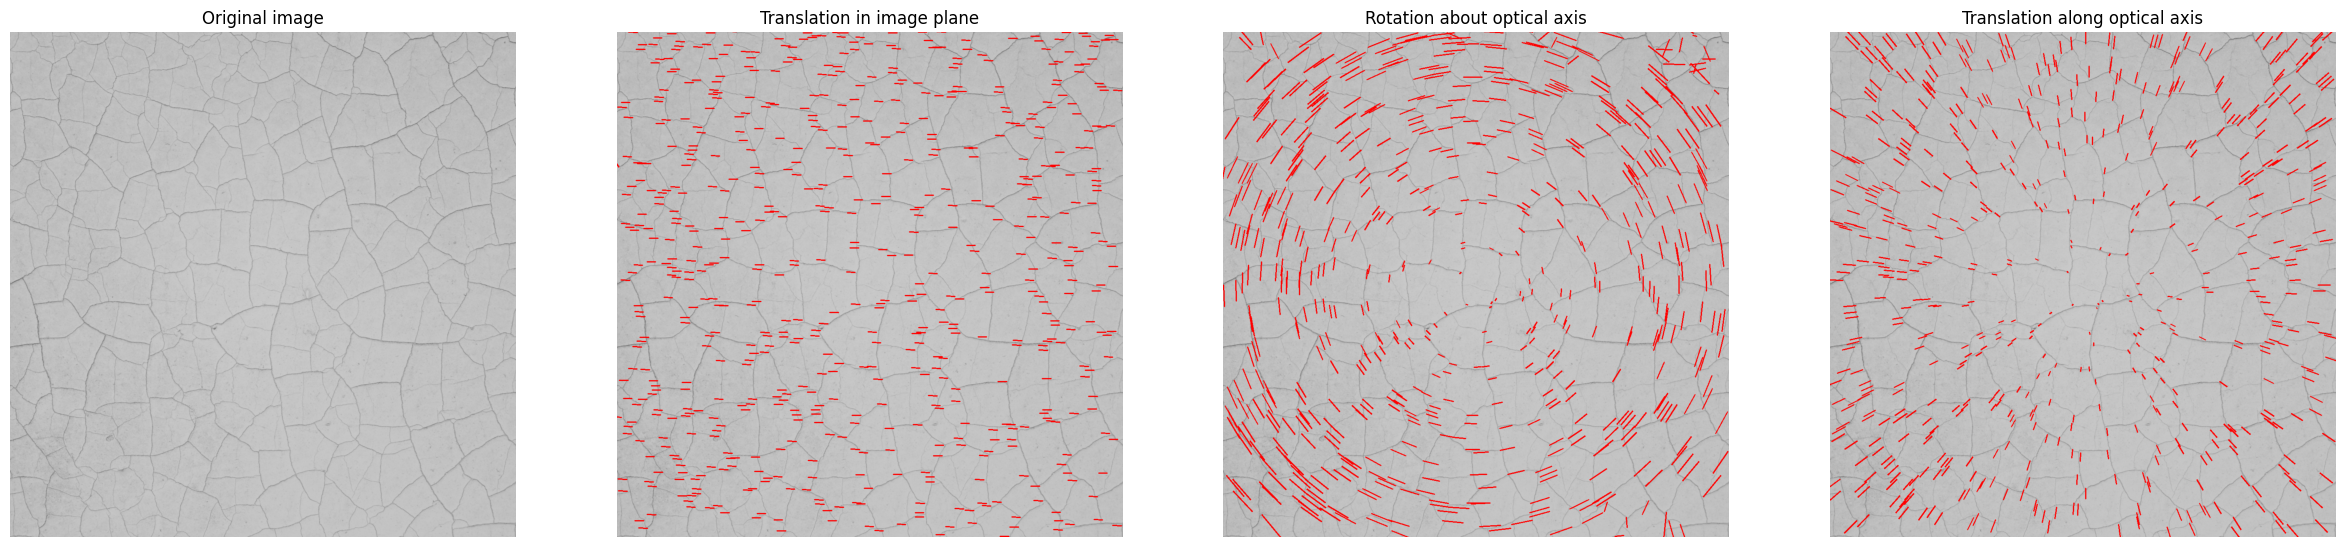

In [ ]:
img_flow = [im1]
for im in imgs:
  img_flow.append(get_optical_flow(im1,im))
plot_imgs(*img_flow)

## Gunnar Farneback (Dense Optical Flow)

In [ ]:
def get_dense_optical_flow(im1, im2):
  # calculate dense optical flow
  flow = cv2.calcOpticalFlowFarneback(im1, im2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

  # encode vector field direction with hue and magnitude with value of HSV format
  mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
  hsv = np.zeros((im1.shape[0], im1.shape[1], 3), dtype = im1.dtype)
  hsv[..., 0] = ang*180/np.pi/2 # hue [0, 360]
  hsv[..., 1] = 255 # let saturation be at the maximum
  hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX) # value
  im_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
  return im_flow, flow

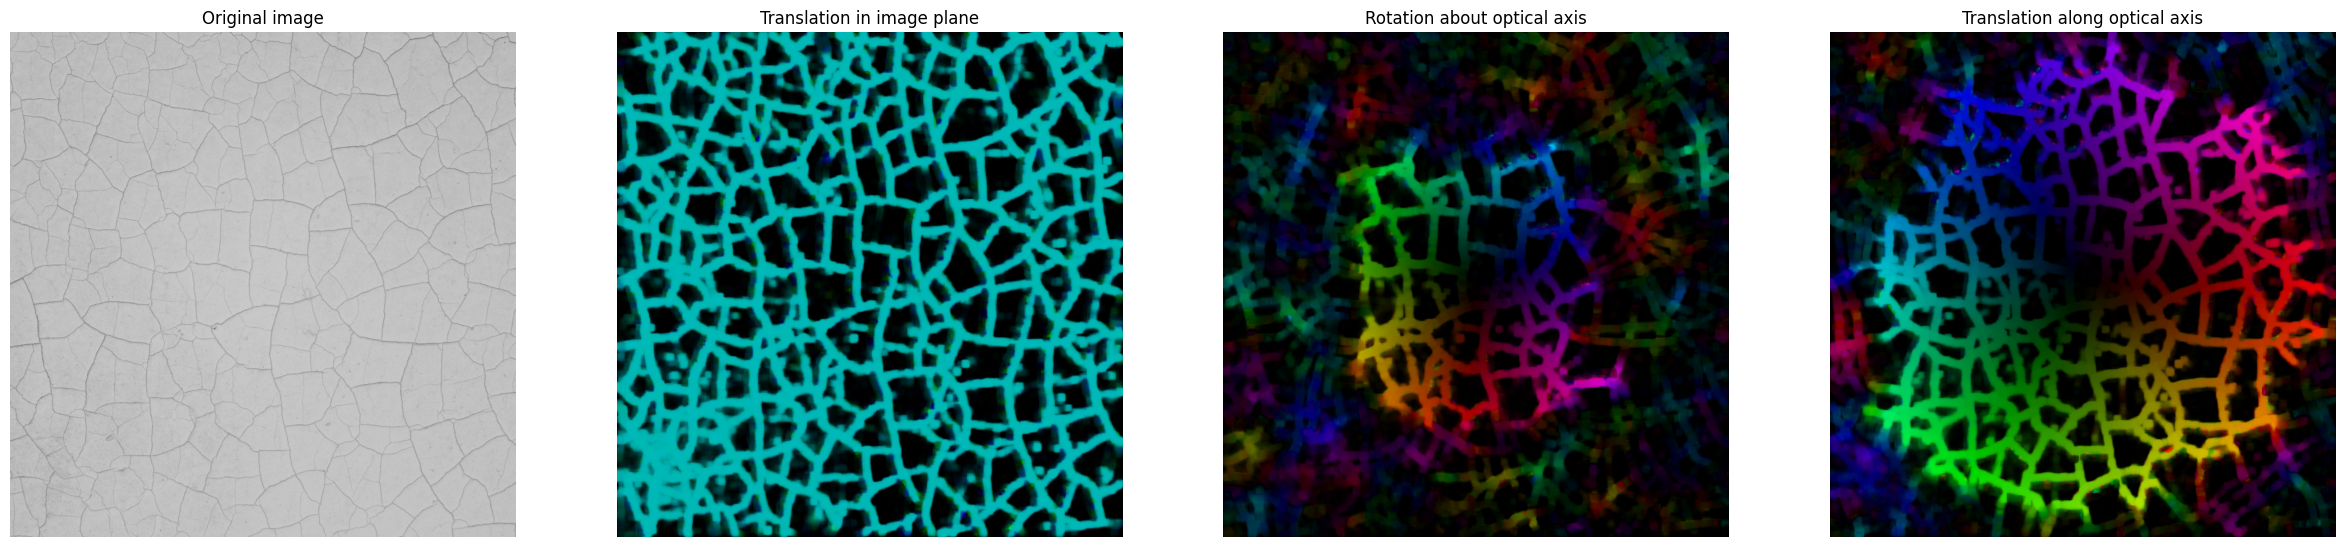

In [ ]:
img_flow1 = [im1]
for im in imgs:
  im_flow, _ = get_dense_optical_flow(im1,im)
  img_flow1.append(im_flow)
plot_imgs(*img_flow1)

## Remap function to imitate optical flow

In [ ]:
# Dense optical flow increments
_, flow = get_dense_optical_flow(im1, im3)

In [ ]:
indices = np.arange(0, 1200, dtype=np.float32)

In [ ]:
# build maps to move pixels of the original image according to the dense optical flow
mapx = indices + flow[..., 0]
mapy =  indices[np.newaxis].T + flow[..., 1]

In [ ]:
# cv2.remap(im, mapx, mapy)  im_new(x,y) = src(mapx(x,y), mapy(x,y))
im1_mapped = cv2.remap(im1, mapx, mapy, cv2.INTER_LINEAR) # interpolation must be bicubic for better precision

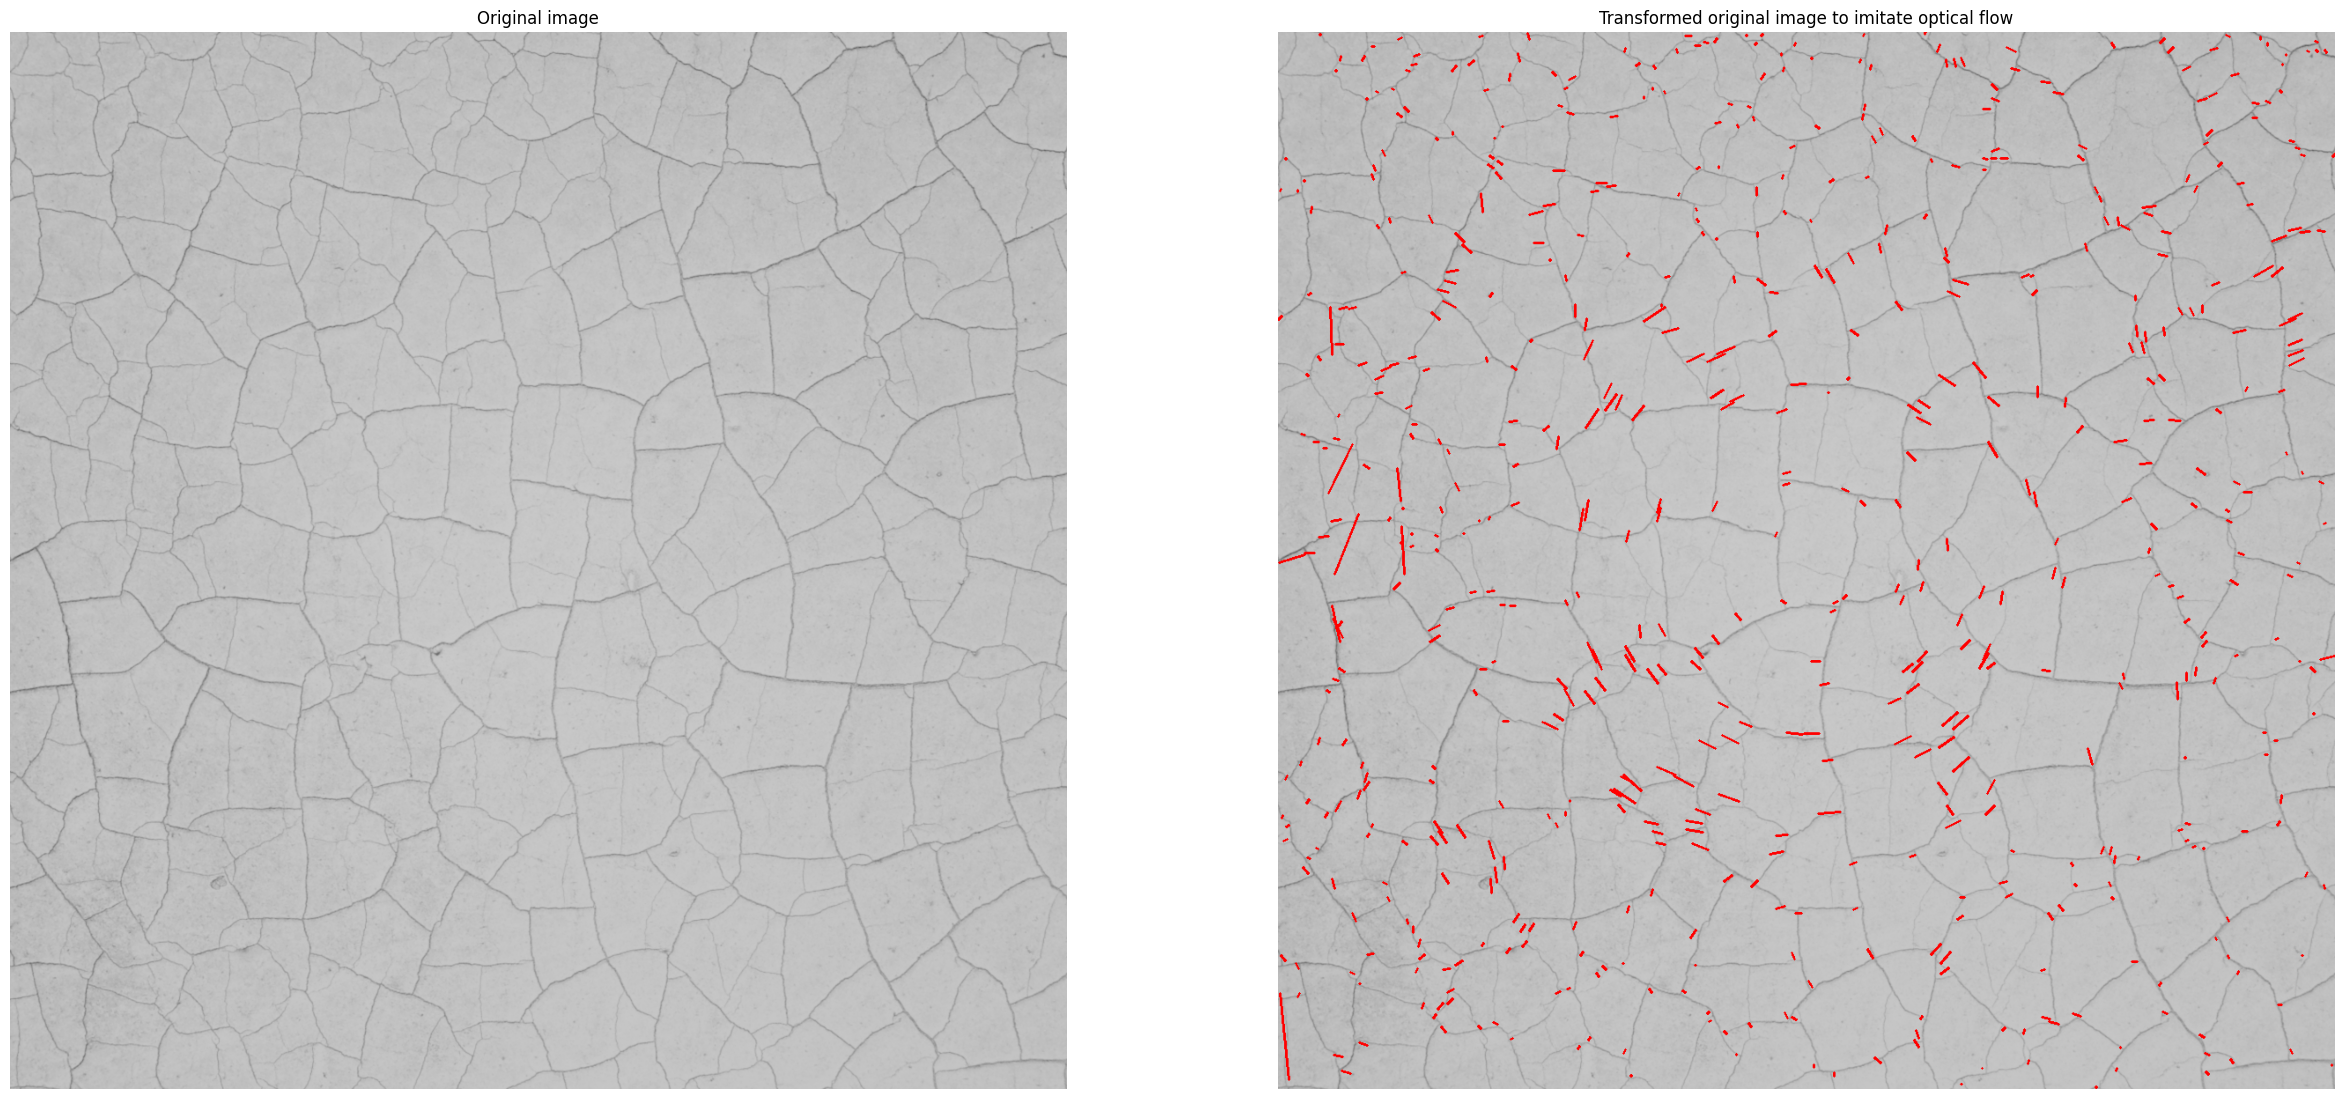

In [ ]:
# plot sparse optical flow
plot_imgs2(im1,  get_optical_flow(im1, im1_mapped))